Ref 1. 
https://towardsdatascience.com/pytorch-shap-explainable-convolutional-neural-networks-ece5f04c374f

Ref 2.
https://github.com/slundberg/shap/blob/master/notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.ipynb

# Part 2 Explainable Convolutional Neural Networks

## Library & Version Check

In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [34]:
# https://nbviewer.org/github/jrjohansson/version_information/blob/master/example.ipynb
%load_ext version_information
%version_information torch, torchvision, numpy, shap

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.8.8 64bit [Clang 10.0.0 ]
IPython 7.29.0
OS macOS 10.16 x86_64 i386 64bit
torch 1.10.0
torchvision 0.11.1
numpy 1.19.5
shap 0.40.0
Thu Nov 25 22:46:33 2021 KST

## Defining the model architecture

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

## Training the model

- `batch_size` - how many images are shown to the model at once
- `num_epochs` - number of complete passes through the training dataset
- `device` - specifies is the training done on CPU or GPU.

In [5]:
batch_size = 128
num_epochs = 5
# device = torch.device('cuda:0') # GPU가 있는 경우 GPU를 설정
device = torch.device('cpu')

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Next, you can download the datasets with the torchvision.datasets module. The datasets are then loaded and transformed (conversion to tensor and normalization) and organized in batches:

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])

train_set = datasets.MNIST('data/', train=True, download=True, transform=transform)
test_set = datasets.MNIST('data/', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [7]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.358203
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.180875
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.644866
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.413392
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.490457

Test set: Average loss: 0.0026, Accuracy: 9397/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.495456
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.539758
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.327798
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.319940
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.374250

Test set: Average loss: 0.0014, Accuracy: 9588/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.373953
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.285385
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.226135
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.217704
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.226057

Test set: Average loss: 0.0011, Accuracy: 9670/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.208395
Train Epoch: 4 [12800/60000 (21%)]	Lo

## Interpreting the model
  
Prediction interpretation is now as simple as writing a couple of lines of code. The following snippet loads in a batch of random images from the test set and interprets predictions for five of them:

In [61]:
batch = next(iter(test_loader))
images, _ = batch

background = images[:100].to(device)
test_images = images[100:110].to(device)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [62]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

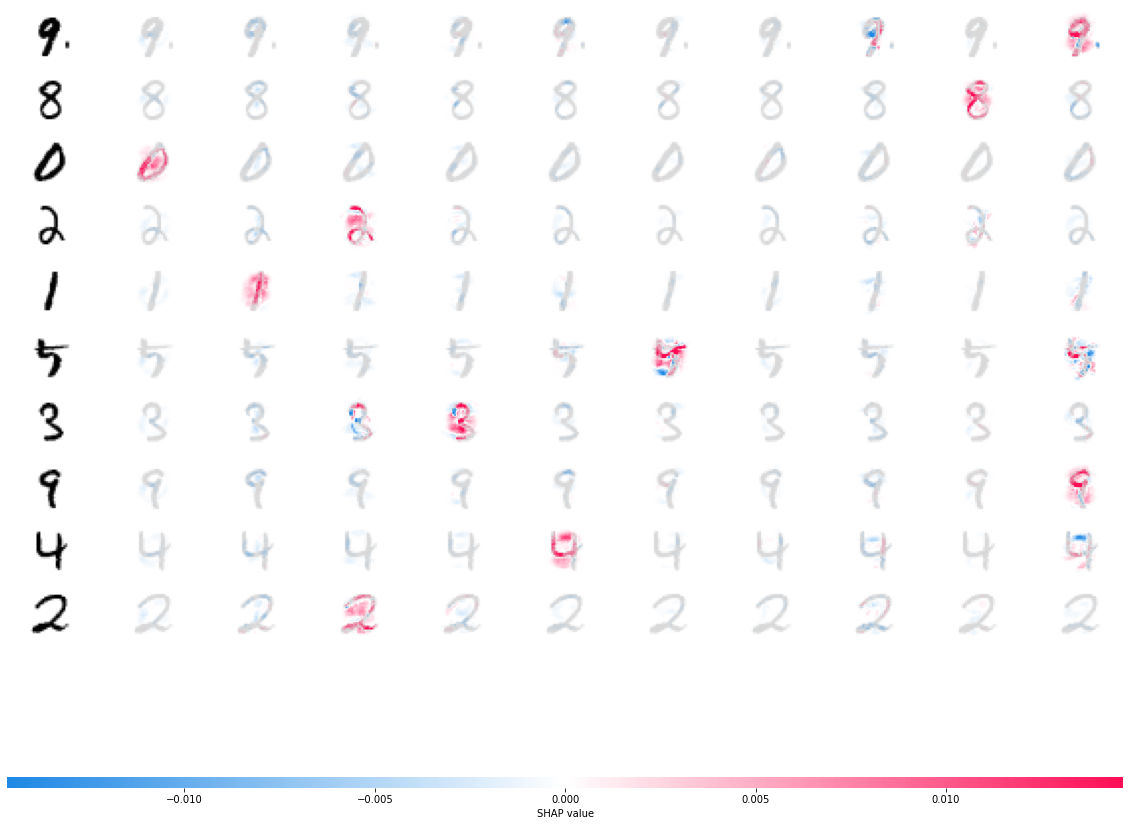

In [63]:
shap.image_plot(shap_numpy, -test_numpy)

왼쪽에는 입력 이미지가 표시되고 오른쪽에는 0~9까지의 각 클래스에 대한 해석이 표시됩니다.  
빨간색으로 색칠된 부분은 모델 예측(=분류)에 (+)기여하며(모델은 분류에 대해 더 확신함)  
파란색으로 색칠된 부분은 모델 예측(=분류)에 (-)기여합니다.

shap.DeepExplainer에 대한 API Reference는 아래에서 확인이 가능합니다.

ref. https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html#shap.DeepExplainer